# LSTM with Multiple Word Embeddings

Team Member: Jade ISIMBI TUZINDE
Model: LSTM
Embedding: TF-IDF, Word2Vec (Skip-gram),CBOW



## 1. Setup & Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
from gensim.models import Word2Vec


try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


sns.set(style="whitegrid")
RANDOM_STATE = 42
MAX_SEQ_LEN = 200
EMBEDDING_DIM = 100
LSTM_UNITS = 128
EPOCHS = 15
BATCH_SIZE = 64

## 2. Load Data

In [9]:
DATA_PATH = '../data/IMDB Dataset.csv'
if not os.path.exists(DATA_PATH):
    print(f"Warning: {DATA_PATH} not found. Please ensure the dataset is in the data folder.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully: {df.shape}")
    display(df.head())

Dataset loaded successfully: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Exploratory Data Analysis (EDA)
Understanding the dataset characteristics.

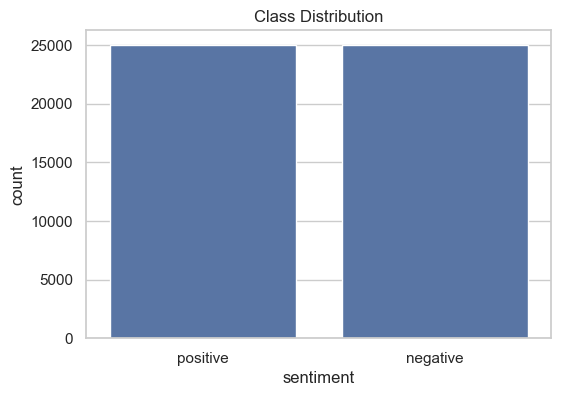

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [10]:
if 'sentiment' in df.columns:
    # Class Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sentiment', data=df)
    plt.title('Class Distribution')
    plt.show()
    print(df['sentiment'].value_counts())

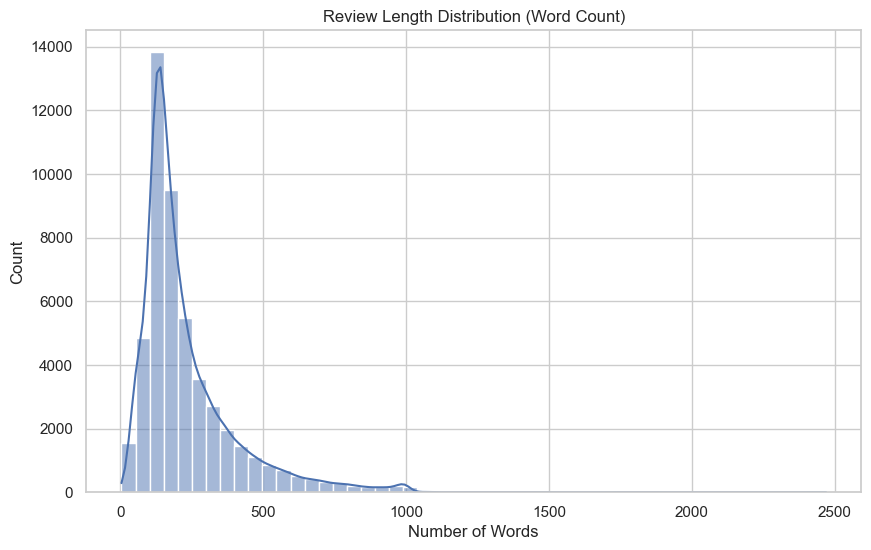

Average word count: 231.16


In [11]:
# Review Length Analysis
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Review Length Distribution (Word Count)')
plt.xlabel('Number of Words')
plt.show()

print(f"Average word count: {df['word_count'].mean():.2f}")

## 4. Preprocessing
Applying shared preprocessing strategy:
1. Lowercase
2. Remove HTML tags
3. Remove special characters
4. Tokenize
5. Remove stopwords (Optional based on embedding)

In [12]:
def clean_text(text, remove_stopwords=True):
    # 1. Lowercase
    text = text.lower()
    # 2. HTML tag removal
    text = re.sub(r'<.*?>', '', text)
    # 3. Remove non-alphanumeric characters (preserving spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 4. Tokenize
    tokens = word_tokenize(text)
    
    # 5. Remove stopwords (Optional based on embedding)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [w for w in tokens if w not in stop_words]
        return " ".join(filtered_tokens)
    else:
        return " ".join(tokens)

# Apply cleaning (Default strategy)
print("Preprocessing data (this may take a moment)...")
df['cleaned_review'] = df['review'].apply(lambda x: clean_text(x, remove_stopwords=True))
display(df[['review', 'cleaned_review']].head())

Preprocessing data (this may take a moment)...


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


### Post-Preprocessing Visualization

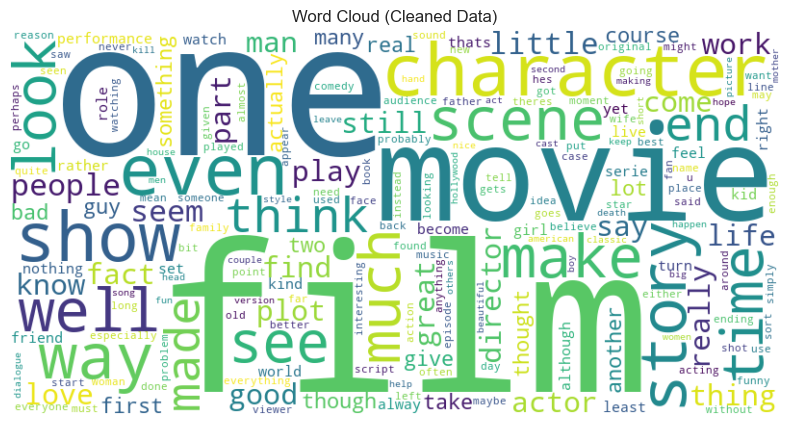

In [13]:
# Word Cloud for cleaned text
all_text = " ".join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Cleaned Data)')
plt.show()

In [14]:
# Train/Test Split
X = df['cleaned_review'].values
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values # Binary encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 40000
Testing samples: 10000


## 5. Embedding Layer & LSTM Training
Preprocessing is adapted per embedding:
- **TF-IDF:** Uses shared preprocessing with stopword removal. Documents are vectorized with `TfidfVectorizer(max_features=500)` and reshaped to sequences for LSTM.
- **Skip-gram / CBOW:** Uses tokenized text without stopword removal to preserve context for Word2Vec. Tokenizer and padded sequences are built from the same tokenization; embedding matrices are filled from trained Word2Vec (Skip-gram: `sg=1`, CBOW: `sg=0`).


In [22]:
# Prepare tokenized sentences for Word2Vec (Skip-gram and CBOW).
# For Word2Vec we use preprocessing without stopword removal to preserve context (common practice).
def get_tokenized_sentences(texts):
    return [clean_text(t, remove_stopwords=False).split() for t in texts]

def build_sequences_and_embedding_matrix(X_train_tok, X_test_tok, w2v_model, max_seq_len=MAX_SEQ_LEN, embedding_dim=EMBEDDING_DIM):
    """Build tokenizer, padded sequences, and embedding matrix from tokenized texts and a Word2Vec model."""
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts([' '.join(s) for s in X_train_tok])
    vocab_size = len(tokenizer.word_index) + 1

    X_train_seq = pad_sequences(
        tokenizer.texts_to_sequences([' '.join(s) for s in X_train_tok]),
        maxlen=max_seq_len, padding='post', truncating='post'
    )
    X_test_seq = pad_sequences(
        tokenizer.texts_to_sequences([' '.join(s) for s in X_test_tok]),
        maxlen=max_seq_len, padding='post', truncating='post'
    )

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size and word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

    return tokenizer, X_train_seq, X_test_seq, embedding_matrix, vocab_size

def compute_metrics(y_true, y_pred):
    """Compute Accuracy, Precision, Recall, and F1 for binary classification."""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='binary', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='binary', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='binary', zero_division=0),
    }

X_train_tok = get_tokenized_sentences(X_train)
X_test_tok = get_tokenized_sentences(X_test)

# Store results for comparative analysis
results_list = []

In [23]:
# --- 1. LSTM with TF-IDF ---
# Preprocessing for TF-IDF: use cleaned text (stopwords removed). LSTM receives document as sequence of feature dimensions.
clear_session()
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 1), min_df=2, max_df=0.95)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()
# Reshape for LSTM: (samples, timesteps, features) -> each document is one "sequence" of 500 TF-IDF values
X_train_tfidf_seq = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_test_tfidf_seq = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

model_tfidf = Sequential([
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False), input_shape=(X_train_tfidf_seq.shape[1], 1)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_tfidf = model_tfidf.fit(X_train_tfidf_seq, y_train, validation_data=(X_test_tfidf_seq, y_test),
                                epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
y_pred_tfidf = (model_tfidf.predict(X_test_tfidf_seq) > 0.5).astype(int).flatten()
metrics_tfidf = compute_metrics(y_test, y_pred_tfidf)
results_list.append({'embedding': 'TF-IDF', **metrics_tfidf})
print(f"TF-IDF — Accuracy: {metrics_tfidf['accuracy']:.4f}, Precision: {metrics_tfidf['precision']:.4f}, Recall: {metrics_tfidf['recall']:.4f}, F1: {metrics_tfidf['f1']:.4f}")

Epoch 1/10


/Users/jade/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 72ms/step - accuracy: 0.5227 - loss: 0.6910 - val_accuracy: 0.5678 - val_loss: 0.6819
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.5746 - loss: 0.6758 - val_accuracy: 0.5771 - val_loss: 0.6748
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 71ms/step - accuracy: 0.5854 - loss: 0.6701 - val_accuracy: 0.5746 - val_loss: 0.6760
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.5907 - loss: 0.6698 - val_accuracy: 0.5926 - val_loss: 0.6677
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.5947 - loss: 0.6666 - val_accuracy: 0.5960 - val_loss: 0.6648
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 187s 299ms/step - accuracy: 0.5922 - loss: 0.6658 - val_accuracy: 0.5870 - val_loss: 0.6664
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.5927 - loss: 0.6643 - val_accuracy: 0.5773 - val_loss: 0.6705
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.5915 - loss: 0.6641 - val_accur

In [24]:
# --- 2. LSTM with Skip-gram (Word2Vec) ---
# Skip-gram: sg=1. Train on tokenized training corpus only.
clear_session()
w2v_skip = Word2Vec(sentences=X_train_tok, vector_size=EMBEDDING_DIM, window=5, min_count=2, sg=1, epochs=10, seed=RANDOM_STATE, workers=1)
_, X_train_seq_skip, X_test_seq_skip, embedding_matrix_skip, vocab_size_skip = build_sequences_and_embedding_matrix(
    X_train_tok, X_test_tok, w2v_skip
)

model_skip = Sequential([
    Embedding(vocab_size_skip, EMBEDDING_DIM, weights=[embedding_matrix_skip], input_length=MAX_SEQ_LEN, trainable=True),
    LSTM(LSTM_UNITS, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_skip.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_skip = model_skip.fit(X_train_seq_skip, y_train, validation_data=(X_test_seq_skip, y_test),
                               epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
y_pred_skip = (model_skip.predict(X_test_seq_skip) > 0.5).astype(int).flatten()
metrics_skip = compute_metrics(y_test, y_pred_skip)
results_list.append({'embedding': 'Skip-gram', **metrics_skip})
print(f"Skip-gram — Accuracy: {metrics_skip['accuracy']:.4f}, Precision: {metrics_skip['precision']:.4f}, Recall: {metrics_skip['recall']:.4f}, F1: {metrics_skip['f1']:.4f}")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

Epoch 1/10


/Users/jade/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.5194 - loss: 0.6891 - val_accuracy: 0.5308 - val_loss: 0.6857
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.5502 - loss: 0.6683 - val_accuracy: 0.5326 - val_loss: 0.6776
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.8041 - loss: 0.4634 - val_accuracy: 0.7468 - val_loss: 0.5882
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.8767 - loss: 0.3211 - val_accuracy: 0.8061 - val_loss: 0.5723
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.8576 - loss: 0.3499 - val_accuracy: 0.8787 - val_loss: 0.3267
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.9418 - loss: 0.1693 - val_accuracy: 0.8784 - val_loss: 0.3205
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.9553 - loss: 0.1358 - val_accuracy: 0.8814 - val_loss: 0.3156
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.9694 - loss: 0.1139 - val_accurac

In [25]:
# --- 3. LSTM with CBOW (Word2Vec) ---
# CBOW: sg=0. Same tokenization and sequence preparation as Skip-gram.
clear_session()
w2v_cbow = Word2Vec(sentences=X_train_tok, vector_size=EMBEDDING_DIM, window=5, min_count=2, sg=0, seed=RANDOM_STATE, workers=1)
_, X_train_seq_cbow, X_test_seq_cbow, embedding_matrix_cbow, vocab_size_cbow = build_sequences_and_embedding_matrix(
    X_train_tok, X_test_tok, w2v_cbow
)

model_cbow = Sequential([
    Embedding(vocab_size_cbow, EMBEDDING_DIM, weights=[embedding_matrix_cbow], input_length=MAX_SEQ_LEN, trainable=True),
    LSTM(LSTM_UNITS, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_cbow.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cbow = model_cbow.fit(X_train_seq_cbow, y_train, validation_data=(X_test_seq_cbow, y_test),
                              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
y_pred_cbow = (model_cbow.predict(X_test_seq_cbow) > 0.5).astype(int).flatten()
metrics_cbow = compute_metrics(y_test, y_pred_cbow)
results_list.append({'embedding': 'CBOW', **metrics_cbow})
print(f"CBOW — Accuracy: {metrics_cbow['accuracy']:.4f}, Precision: {metrics_cbow['precision']:.4f}, Recall: {metrics_cbow['recall']:.4f}, F1: {metrics_cbow['f1']:.4f}")

Epoch 1/10


/Users/jade/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - accuracy: 0.5476 - loss: 0.6814 - val_accuracy: 0.7669 - val_loss: 0.5223
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.6658 - loss: 0.5965 - val_accuracy: 0.5425 - val_loss: 0.6729
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.5375 - loss: 0.6743 - val_accuracy: 0.5389 - val_loss: 0.6703
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.6280 - loss: 0.6306 - val_accuracy: 0.6247 - val_loss: 0.6252
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.6752 - loss: 0.5840 - val_accuracy: 0.8379 - val_loss: 0.4194
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.7900 - loss: 0.4847 - val_accuracy: 0.8319 - val_loss: 0.4171
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.8464 - loss: 0.3923 - val_accuracy: 0.8667 - val_loss: 0.3370
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.9147 - loss: 0.2505 - val_accurac

## 6. Comparison table

In [26]:

results_df = pd.DataFrame(results_list)

embedding_order = ['TF-IDF', 'Skip-gram', 'CBOW']
results_df = (
    results_df.sort_values('f1', ascending=False)
    .drop_duplicates(subset=['embedding'], keep='first')
)
results_df['embedding'] = pd.Categorical(results_df['embedding'], categories=embedding_order, ordered=True)
results_df = results_df.sort_values('embedding').reset_index(drop=True)

display(results_df)

,embedding,accuracy,precision,recall,f1
0,TF-IDF,0.5888,0.578440,0.678309,0.624406
1,Skip-gram,0.8659,0.827605,0.926970,0.874473
2,CBOW,0.8747,0.883509,0.865449,0.874386


## 7. Training Summary


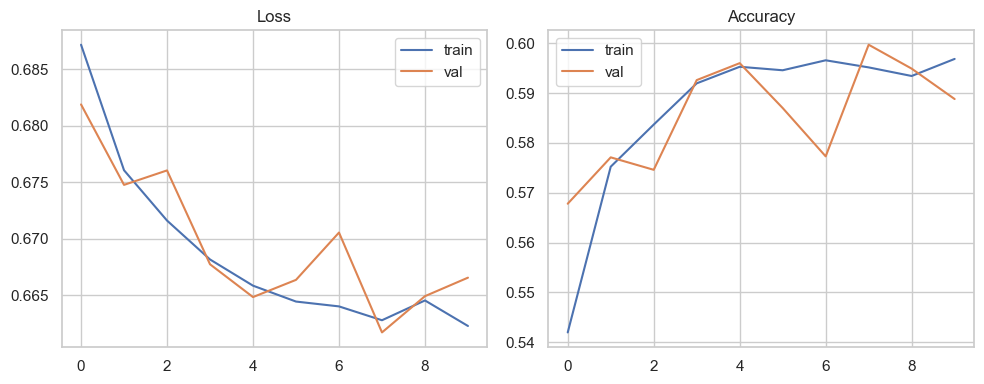

In [27]:

if 'history_tfidf' in dir():
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tfidf.history['loss'], label='train')
    plt.plot(history_tfidf.history['val_loss'], label='val')
    plt.legend(); plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history_tfidf.history['accuracy'], label='train')
    plt.plot(history_tfidf.history['val_accuracy'], label='val')
    plt.legend(); plt.title('Accuracy')
    plt.tight_layout(); plt.show()

## 8.  Comparison Table

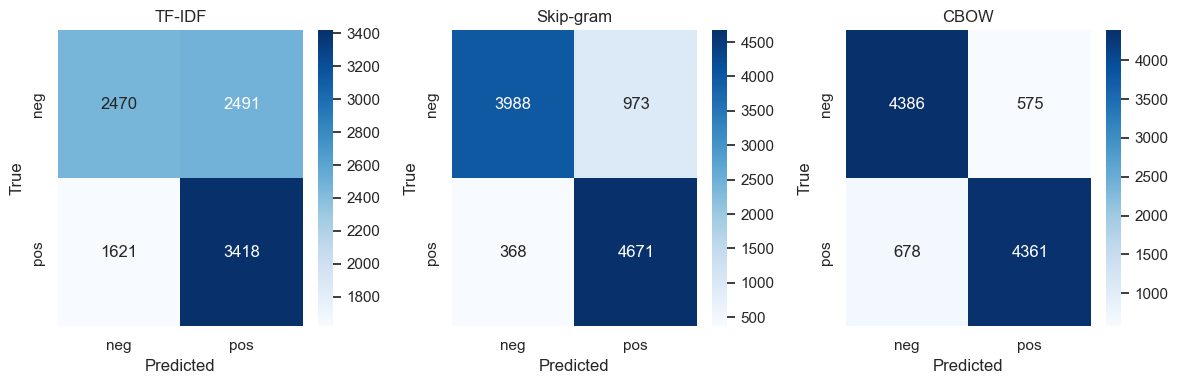

Evaluation metrics (Accuracy, Precision, Recall, F1):
embedding  accuracy  precision   recall       f1
   TF-IDF    0.5888   0.578440 0.678309 0.624406
Skip-gram    0.8659   0.827605 0.926970 0.874473
     CBOW    0.8747   0.883509 0.865449 0.874386


In [28]:
# Confusion matrices for each embedding
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
preds = [y_pred_tfidf, y_pred_skip, y_pred_cbow]
names = ['TF-IDF', 'Skip-gram', 'CBOW']
for ax, y_pred, name in zip(axes, preds, names):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(name)
plt.tight_layout(); plt.show()

# Evaluation metrics: Accuracy, Precision, Recall, F1 — comparison across embeddings
print("Evaluation metrics (Accuracy, Precision, Recall, F1):")
print(results_df.to_string(index=False))